In [7]:
# Add Project Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import utils, ERA

import netCDF4

import numpy as np
import pandas as pd

from eofs.standard import Eof

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import os

In [8]:
# TODO: Add Cosine Latitude Weights

In [9]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")

In [10]:
def plot_earth(view="EARTH"):
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [25, 10]

    # create Projection and Map Elements
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.OCEAN, color="white")
    ax.add_feature(cfeature.LAND, color="lightgray")

    if view == "US":
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
    elif view == "EAST US":
        ax.set_xlim(-105, -65)
        ax.set_ylim(25, 50)
    elif view == "EARTH":
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
    
    return ax, projection

def mask_plot(mask):
    mask_float = mask.astype(np.float)
    mask_float[mask==0] = np.NaN
    return mask_float

## NOAA Oceanic Niño Index (ONI)
sea surface temperature anomaly index for Niño 3.4 (5°N to 5°S, 170°W to 120°W)

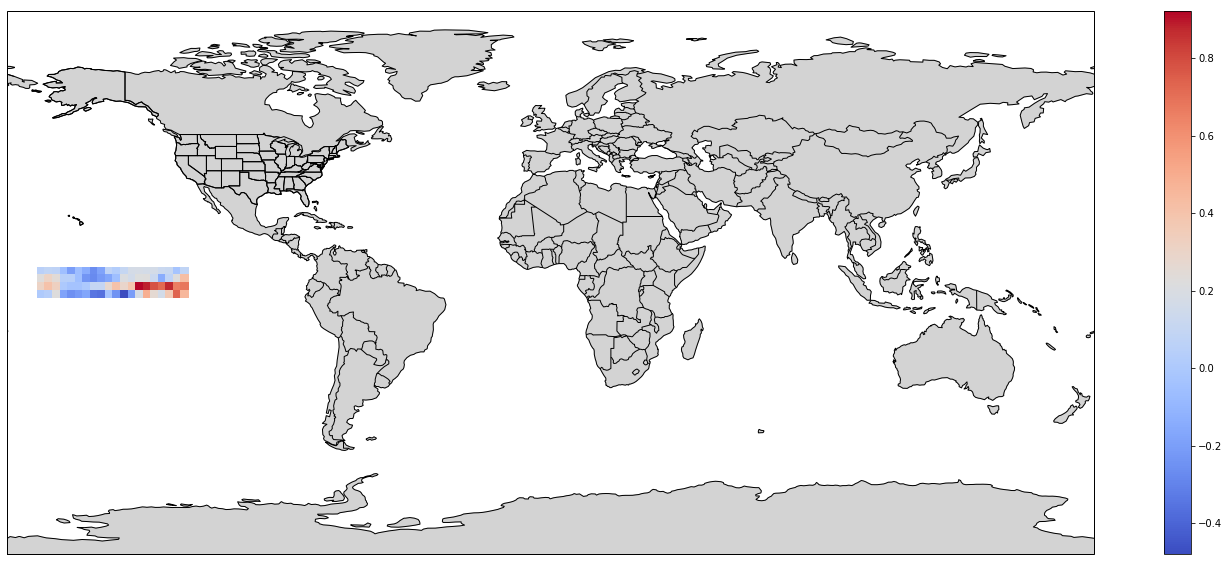

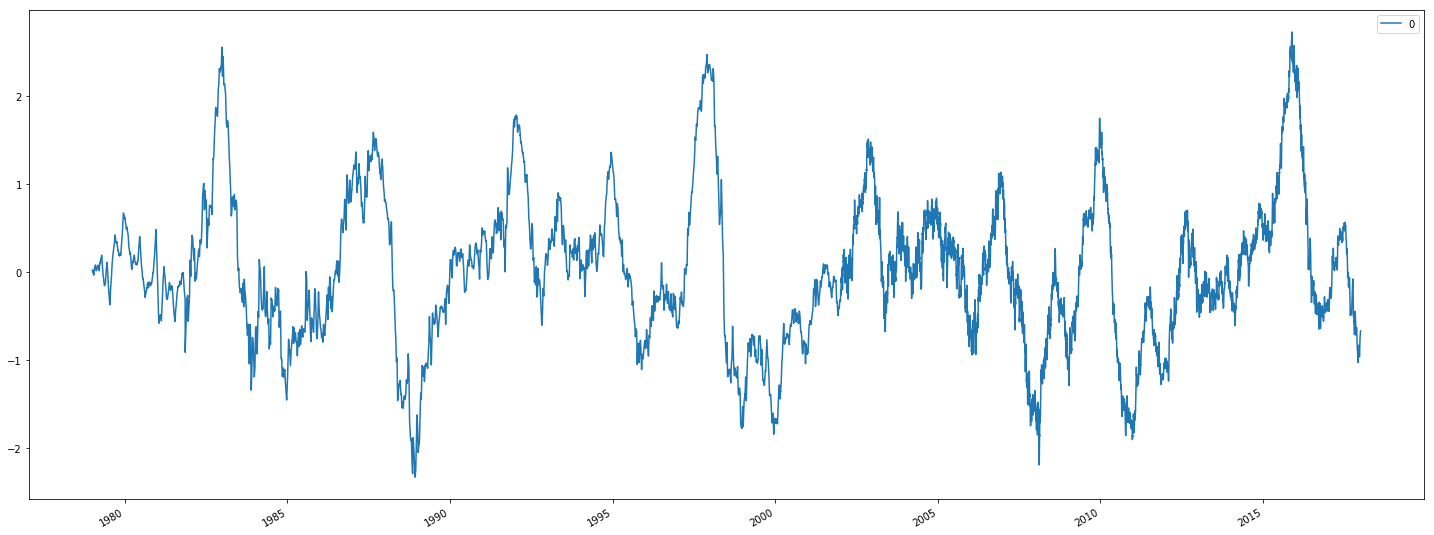

In [11]:
# Load Sea Surface Temperatures (SST)
TARGET = os.path.join(DATA_ROOT, 'ERA', 'sst_1979-2017_1_12_daily_2.5deg.nc')
SST = ERA(TARGET, 'sst')

SST_LATITUDE_MASK = np.nonzero((SST.latitude >= -5) * (SST.latitude <= 5))[0]
SST_LONGITUDE_MASK = np.nonzero((SST.longitude >= 190) * (SST.longitude <= 240))[0]

SST = ERA(TARGET, 'sst', index=(None, SST_LATITUDE_MASK, SST_LONGITUDE_MASK))

# Calculate ONI Index
ONI_INDEX = pd.DataFrame(SST.anomaly.reshape(len(SST.time), -1).mean(1), index=SST.time.index)

# Save ONI Index to Disk
ONI_INDEX.to_csv(os.path.join(DATA_ROOT, 'features', 'ONI.csv'), header=False)

# Plot ONI Region
ax, projection = plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, SST.anomaly[0], cmap='coolwarm', transform=projection)
plt.colorbar()
plt.show()

# Plot ONI Index
ONI_INDEX.plot()
plt.show()

# North Atlantic Oscillation

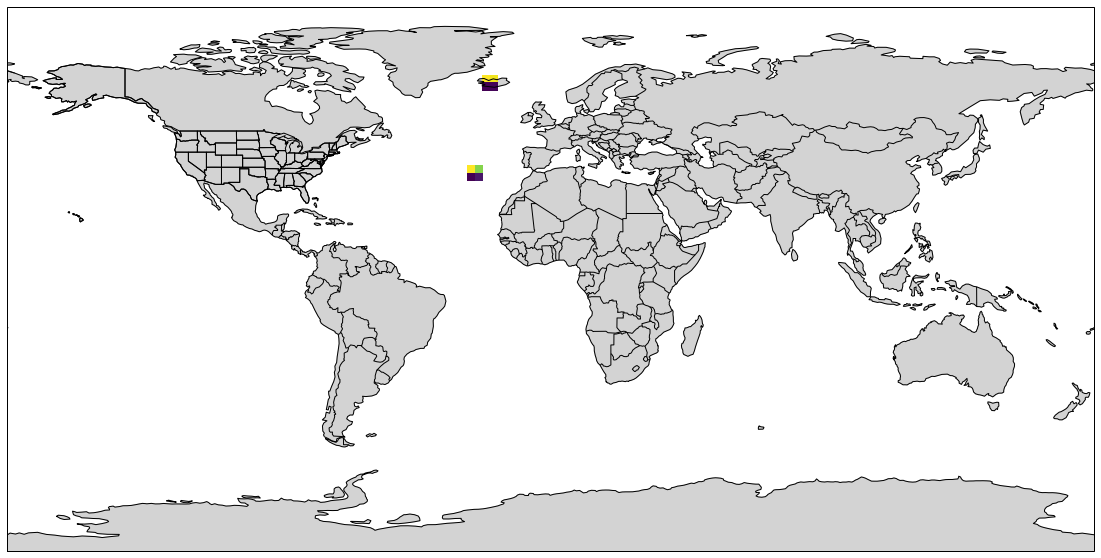

In [12]:
TARGET = os.path.join(DATA_ROOT, 'ERA', 'SLP_1979-2017_1jan_31dec_dt-1days_2.5deg.nc')
SLP = ERA(TARGET, 'msl', time_origin='1979-01-01', time_unit='D')

ICELAND_LATITUDE_MASK = np.nonzero((SLP.latitude > 60) * (SLP.latitude < 70))[0]
ICELAND_LONGITUDE_MASK = np.nonzero((SLP.longitude > 335) * (SLP.longitude < 345))[0]

SLP_ICELAND = ERA(TARGET, 'msl', index=(None, ICELAND_LATITUDE_MASK, ICELAND_LONGITUDE_MASK), time_origin='1979-01-01', time_unit='D')

AZORES_LATITUDE_MASK = np.nonzero((SLP.latitude > 30) * (SLP.latitude < 40))[0]
AZORES_LONGITUDE_MASK = np.nonzero((SLP.longitude > 330) * (SLP.longitude < 340))[0]

SLP_AZORES = ERA(TARGET, 'msl', index=(None, AZORES_LATITUDE_MASK, AZORES_LONGITUDE_MASK), time_origin='1979-01-01', time_unit='D')

plot_earth()
plt.pcolormesh(SLP_ICELAND.longitude, SLP_ICELAND.latitude, SLP_ICELAND.anomaly[10])
plt.pcolormesh(SLP_AZORES.longitude, SLP_AZORES.latitude, SLP_AZORES.anomaly[10])
plt.show()

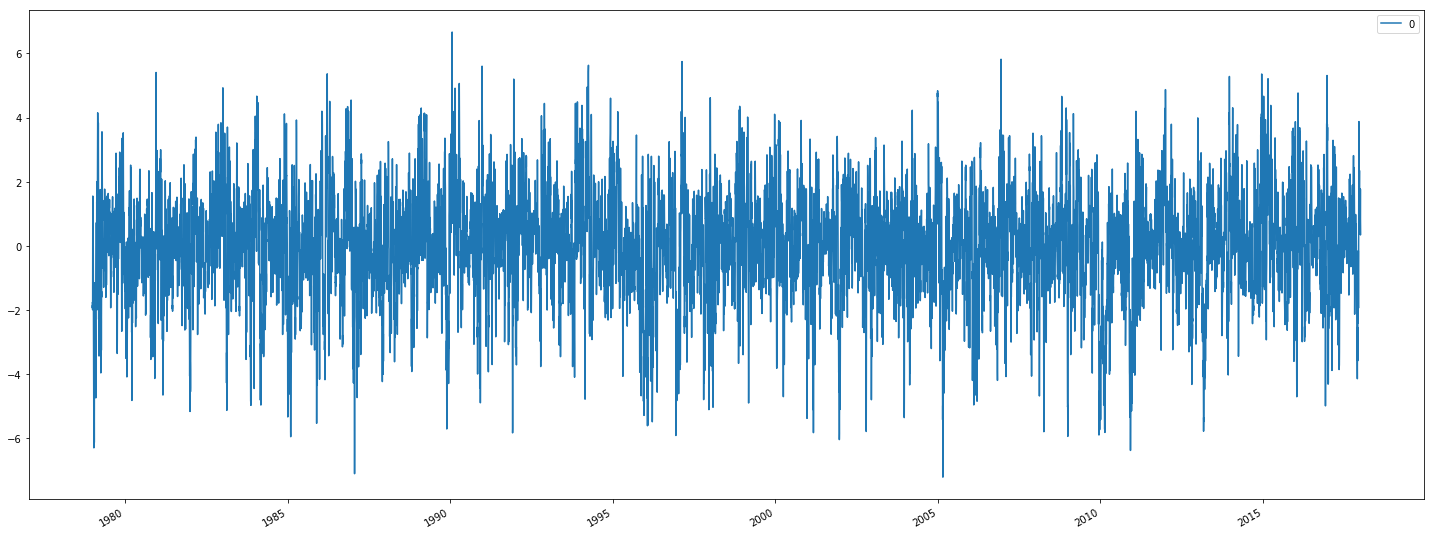

In [13]:
anomaly_north = pd.DataFrame(SLP_ICELAND.anomaly.mean(axis=(1,2)), index=SLP_ICELAND.time.index)
anomaly_south = pd.DataFrame(SLP_AZORES.anomaly.mean(axis=(1,2)), index=SLP_AZORES.time.index)

anomaly_north /= anomaly_north.std()
anomaly_south /= anomaly_south.std()

NAO = (anomaly_south - anomaly_north).fillna(method='ffill')

NAO.to_csv(os.path.join(DATA_ROOT, 'features', 'ERA', 'NAO.csv'), header=False)

NAO.plot()

# Pacific North American (PNA) Pattern

1. $PNA = 0,25 x [Z (20°N, 160°W) - Z (45°N, 165°W) + Z (55°N, 115°W) - Z (30°N, 85°W)]$
2. $PNA = Z * (15°N-25°N, 180-140°W)-Z * (40°N-50°N, 180-140°W) + Z* (45 °N-60°N, 125 °W-105°W)-Z * (25°N-35°N, 90°W-70°W)$

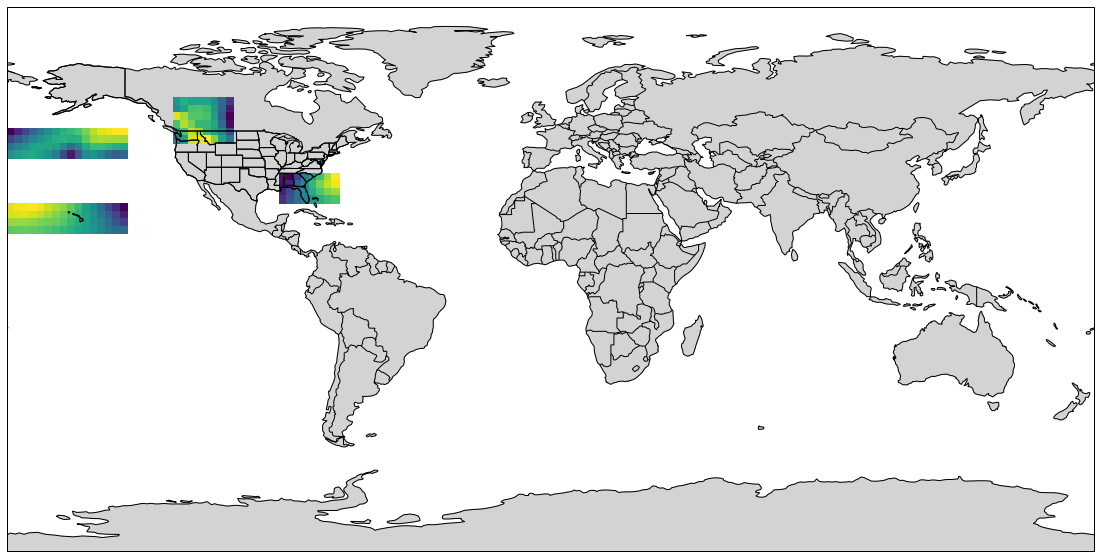

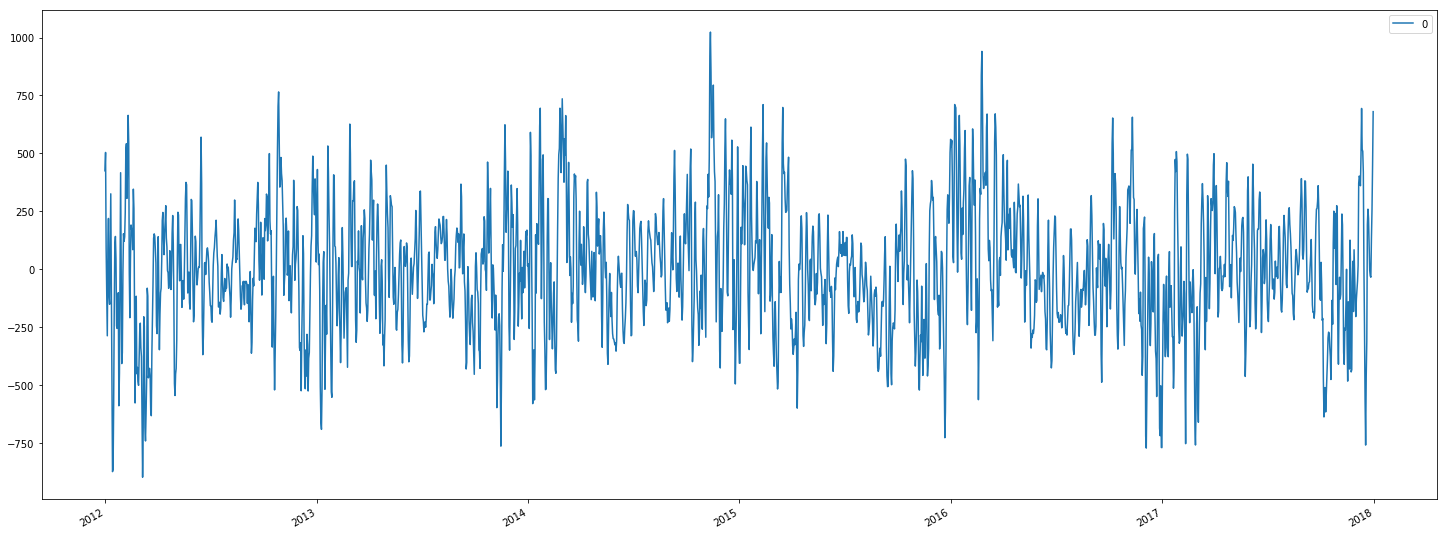

In [14]:
TARGET = os.path.join(DATA_ROOT, 'ERA', 'SLP_1979-2017_1jan_31dec_dt-1days_2.5deg.nc')
SLP = ERA(TARGET, 'msl', time_origin='1979-01-01', time_unit='D')

PNA_1 = ERA(TARGET, 'msl', time_origin='1979-01-01', time_unit='D',
            index=(None, np.nonzero((SLP.latitude >= 15) * (SLP.latitude <= 25))[0],
                         np.nonzero((SLP.longitude >= 180) * (SLP.longitude <= 220))[0]))

PNA_2 = ERA(TARGET, 'msl', time_origin='1979-01-01', time_unit='D',
            index=(None, np.nonzero((SLP.latitude >= 40) * (SLP.latitude <= 50))[0],
                         np.nonzero((SLP.longitude >= 180) * (SLP.longitude <= 220))[0]))

PNA_3 = ERA(TARGET, 'msl', time_origin='1979-01-01', time_unit='D',
            index=(None, np.nonzero((SLP.latitude >= 45) * (SLP.latitude <= 60))[0],
                         np.nonzero((SLP.longitude >= 235) * (SLP.longitude <= 255))[0]))

PNA_4 = ERA(TARGET, 'msl', time_origin='1979-01-01', time_unit='D',
            index=(None, np.nonzero((SLP.latitude >= 25) * (SLP.latitude <= 35))[0],
                         np.nonzero((SLP.longitude >= 270) * (SLP.longitude <= 290))[0]))



plot_earth()
plt.pcolormesh(PNA_1.longitude, PNA_1.latitude, PNA_1.data[0])
plt.pcolormesh(PNA_2.longitude, PNA_2.latitude, PNA_2.data[0])
plt.pcolormesh(PNA_3.longitude, PNA_3.latitude, PNA_3.data[0])
plt.pcolormesh(PNA_4.longitude, PNA_4.latitude, PNA_4.data[0])
plt.show()

PNA_1_A = pd.DataFrame(PNA_1.anomaly.mean(axis=(1,2)), index=SLP.time.index)
PNA_2_A = pd.DataFrame(PNA_2.anomaly.mean(axis=(1,2)), index=SLP.time.index)
PNA_3_A = pd.DataFrame(PNA_3.anomaly.mean(axis=(1,2)), index=SLP.time.index)
PNA_4_A = pd.DataFrame(PNA_4.anomaly.mean(axis=(1,2)), index=SLP.time.index)

PNA = ((PNA_1_A - PNA_2_A + PNA_3_A - PNA_4_A) / 4).fillna(method='ffill')

PNA.to_csv(os.path.join(DATA_ROOT, 'features', 'ERA', 'PNA.csv'), header=False)

PNA["2012":"2017"].plot()
plt.show()

# Pacific Decedal Oscilation

## From ERA

CNP: the central North Pacific (25􏰄–50􏰄N, 160􏰄E–150􏰄W)
- YUAN ZHANG, JOHN M. WALLACE, AND DAVID S. BATTISTI (1996)
- Russ E. Davis (1976)

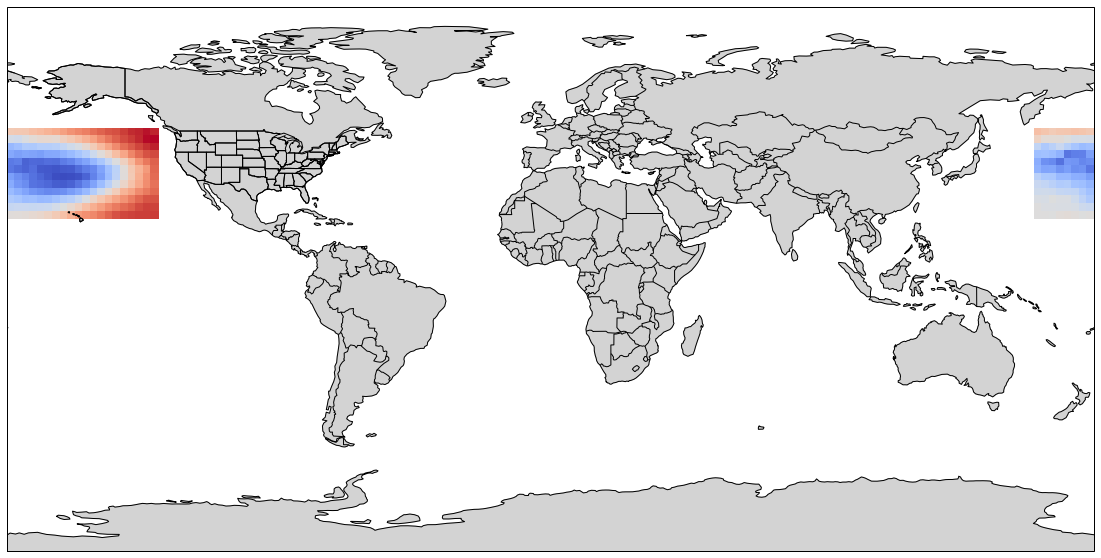

In [16]:
# Load Sea Surface Temperatures (SST)
TARGET = os.path.join(DATA_ROOT, 'ERA', 'sst_1979-2017_1_12_daily_2.5deg.nc')
SST = ERA(TARGET, 'sst')

SST_LATITUDE_MASK = np.nonzero((SST.latitude >= 20) * (SST.latitude <= 50))[0]
SST_LONGITUDE_MASK = np.nonzero((SST.longitude >= 160) * (SST.longitude <= 230))[0]

SST = ERA(TARGET, 'sst', index=(None, SST_LATITUDE_MASK, SST_LONGITUDE_MASK))

eof = Eof(SST.anomaly).eofs()[0]

plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, eof, cmap='coolwarm')
plt.show()

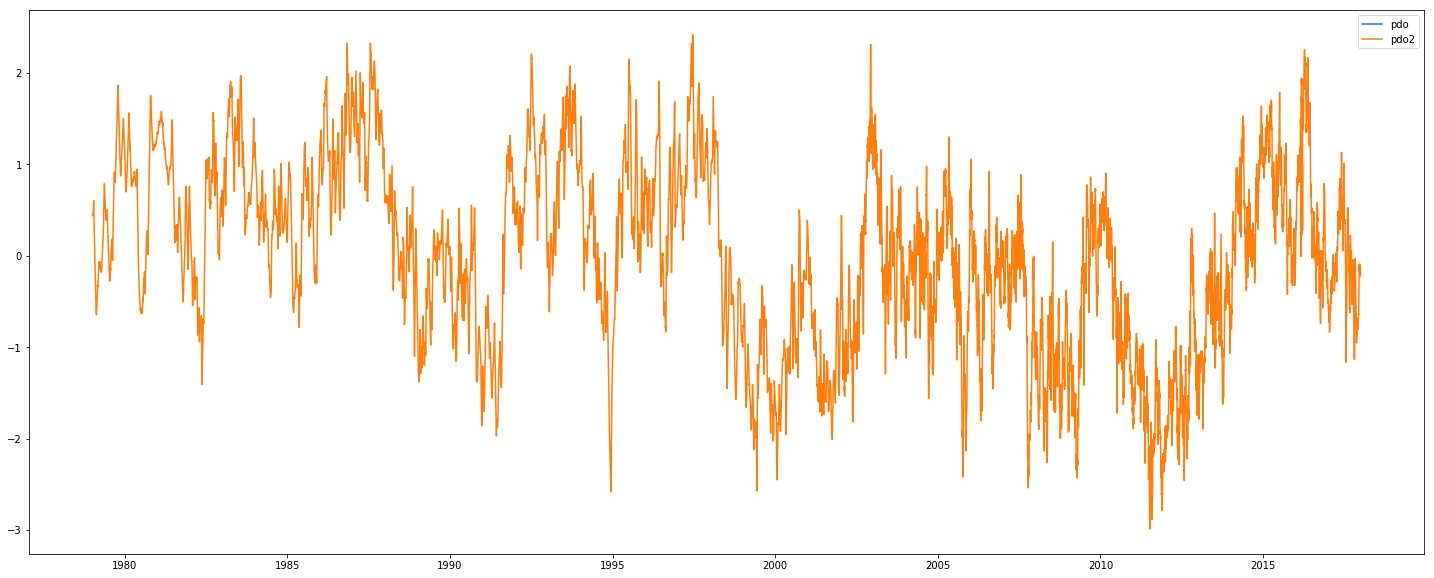

In [17]:
PDO2 = pd.DataFrame((SST.anomaly * eof).mean(axis=(1, 2)), index=SST.time.index)
PDO2 = (PDO2 - PDO2.mean()) / PDO2.std()

PDO2.to_csv(os.path.join(DATA_ROOT, 'features', 'ERA', 'PDO.csv'), header=False)

plt.plot(PDO["1979":], label='pdo')
plt.plot(PDO2["1979":], label='pdo2')
plt.legend()
plt.show()

# Tropical Variability

In [18]:
TARGET = os.path.join(DATA_ROOT, 'ERA', 'prcp_1979-2017_1jan_31okt_dt-1days_2.5deg.nc')
PRCP = ERA(TARGET, 'tp', time_origin='1979-01-01', time_unit='D')

PRCP_JJA = ERA(TARGET, 'tp', time_origin='1979-01-01', time_unit='D',
               index=(PRCP.time[np.logical_and(PRCP.time.index.month >= 6, PRCP.time.index.month <= 8)].values.ravel(),
                      np.nonzero((PRCP.latitude >= -30) * (PRCP.latitude <= 15))[0],
                      None))

PRCP = ERA(TARGET, 'tp', time_origin='1979-01-01', time_unit='D',
           index=(None, np.nonzero((PRCP.latitude >= -30) * (PRCP.latitude <= 15))[0], None))

eof = Eof(PRCP_JJA.rolling(30).mean().anomaly).eofs()[0]

plot_earth()
plt.pcolormesh(PRCP_JJA.longitude, PRCP_JJA.latitude, eof, cmap='coolwarm')
plt.show()

AttributeError: 'ERA' object has no attribute 'rolling'

In [19]:
TV = pd.DataFrame((PRCP.anomaly * eof).mean(axis=(1, 2)), index=PRCP.time.index)
TV = (TV - TV.mean()) / TV.std()

TV = TV.interpolate()

TV.to_csv(os.path.join(DATA_ROOT, 'features', 'ERA', 'TV.csv'), header=False)

TV.plot()

ValueError: operands could not be broadcast together with shapes (12160,32,256) (13,29) 